# Red convolucional con los datos de MNIST

En esta red vamos a crear una red convolucional compuesta por dos capas convolucionales seguidas de dos capas de pooling.

Los datos van a ser las imagenes en escala de grises de MNIST, los dígitos de 0 a 9 escritos a mano

La tarea es la misma, clasificar correctamente cada imagen pero para hacerlo en vez de introducir una matriz one hot vamos a introducir las categorías directamente (números de 0 a 9). Ahora hay que cambiar la función de pérdida a __'sparse_categorical_crossentropy'__.

El resto de los parámetros serán similares:

1. Utilizaremos el optimizador adam con los tres parámetros
1. Dividiremos el conjunto de entrenamiento en train y dev set
1. Mediremos el tiempo de ejecución para ver cuánto tardamos en calcular la red

Las redes convolucionales llevan mucho tiempo de cálculo, una estrategia bastante útil consiste en empezar con un subconjunto mas pequeño del conjunto de entrenamiento para comprobar que todo va bien. Luego cuando hayamos encontrado valores razonables de aprendizaje lo calcularemos con el conjunto completo.


In [38]:
# Librerias necesarias

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import pandas as pd
# versiones de los paquetes
print(tf.__version__)
#print(tf.keras.__version__)

2.13.0


In [3]:
# Definimos la funcion para dibujar la historia

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_loss'],'b',
           label = 'Validation Error')
  # plt.ylim([0,20])
  plt.legend()
  plt.show()


Esta parte es similar a la de la práctica llamada MLP_mnist_onehot por lo que no explicaré mucho, solo los comentarios en el código

11490434/11490434 [==============================] - 1s 0us/step


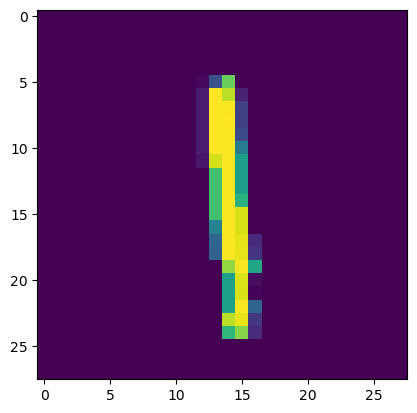

In [4]:
# carga de datos desde Keras, esto ya lo hemos visto en una práctica anterior

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# visualizamos la imagen 8
plt.imshow(x_train[8])
plt.show()


In [5]:
# comprobamos las caracteristicas del set de entrenamiento
print(x_train.ndim)
print(x_train.shape)
print(y_train.ndim)
print(y_train.shape)

3
(60000, 28, 28)
1
(60000,)


In [6]:
# guardamos las dimensiones en variables para hacer la red mas generica
# y reutilizable

ntrain = x_train.shape[0]
ntest  = x_test.shape[0]
dimf = x_train.shape[1]
dimc = x_train.shape[2]

print("dimensiones: ", ntrain, ntest, dimf, dimc)

dimensiones:  60000 10000 28 28


## Preprocesado

Ahora vamos a hacer el preprocesado, pero va a ser un poco diferente.

1. Normalizamos las imágenes entre 0 y 1
1. No vamos a vectorizarlas! las redes convolucionales necesitan que sean imágenes bidimensionales
1. No vamos a hacer la codificación one hot, vamos a dejar y como está

Keras espera que la entrada de cada caso en una red convolucional sea una matriz 3D en la que las dimensiones sean: filas x columnas x color

Normalmente el color se especifica como un vector de tres elementos (RGB o YUV) o los elementos que requiera el espacio de color elegido, pero en nuestro caso solo son grises así que tendremos que la dimensión color solo tendrá un valor. Lo especificamos con el siguiente código:

```
x_train = x_train.reshape(ntrain, dimf, dimc, 1)
x_test = x_test.reshape(ntest, dimf, dimc, 1)
```



In [7]:
# Preprocesamos los datos vectorizando y normalizando las imagenes

x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(ntrain, dimf, dimc, 1)

x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(ntest, dimf, dimc, 1)


# comprobamos que la dimension de x es correcta
print(x_train.shape)
print(x_test.shape)



(60000, 28, 28, 1)
(10000, 28, 28, 1)


Como el conjunto es muy numeroso vamos a crear un subconjunto aleatorio para hacer pruebas y luego calcularemos con el conjunto completo

In [8]:
idx = np.random.randint(60000, size=1000) # elegimos 1000 imagenes de las 60000

x_train_small = x_train[idx,:,:]
y_train_small = y_train[idx]

Vamos a definir la red:

```
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
```
Indica una capa convolucional con 32 kernels de dimensiones 5x5, la función de activación es 'relu' y la entrada es para cada caso una matriz de 28x28x1



```
model.add(MaxPooling2D((2,2)))
```
Se hace un pooling de la capa anterior usando una ventana de 2x2 y se elige el valor más alto de la ventana

Por último se pone una capa densa de perceptrones con 'softmax' para hacer la clasificación. Para ello antes hemos tenido que 'aplanar' (pasar de matrices 2D a vectores 1D), si no, no se podrían aplicar los perceptrones.

```
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
```


In [48]:
# MODEL --------------------------------------------------------------------
# Definimos el modelo

model = tf.keras.Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (5,5), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.01)))
#model.summary()

In [14]:
# Compilamos el modelo ------------------

# model.compile(
#     loss = 'sparse_categorical_crossentropy',
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.2, beta_1=0.1),
#     metrics = ['accuracy'])

In [49]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.1),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9),
    metrics = ['accuracy'])

In [50]:
# Ajustamos el modelo -------------------
# fijate que usamos el conjunto small para ser mas rapidos


start = time.time()
history = model.fit(x_train_small, y_train_small,
              batch_size=100,           # proporcional al conjunto de datos
              epochs=30,
              validation_split = 0.2,   # partimos en train y dev
              verbose=0)                # para que no ocupe toda la pantalla
end = time.time()
print('Tiempo de ejecución:', end - start)

Tiempo de ejecución: 13.898090600967407


El tiempo de ejecución es alto. Hay que tenerlo en cuenta.

Ahora evaluamos los resultados

In [51]:
test_loss, test_acc = model.evaluate(x_train_small, y_train_small)
print('Test accuracy:', test_acc)

32/32 [==============================] - 0s 4ms/step - loss: 0.3320 - accuracy: 0.9810
Test accuracy: 0.9810000061988831


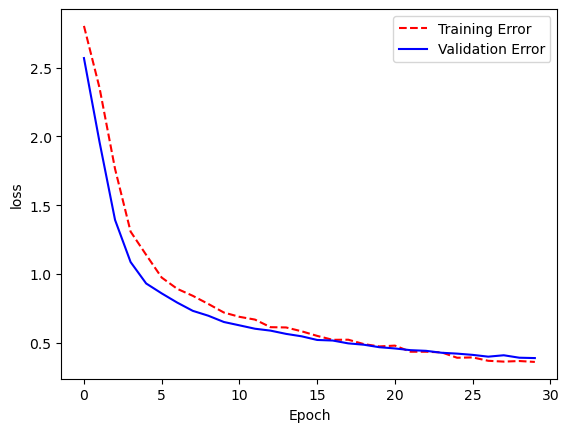

In [52]:
plot_history(history)


Como ves el aprendizaje es un desastre. Prueba con distintos parámetros e hiperparámetros y cuando consideres que la red funciona correctamente puedes ajustarla con el set grande que contiene todas las imágenes

# Ejercicio


Una vez que hayas encontrado una buena red con una buena configuración de parámetros e hiperparámetros contesta el ejercicio de moodle

